# PROYECTO DETECCION TEMPRANA DE MELANOMAS

In [1]:
import os
import zipfile
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

## 1.- BASE DE DATOS

In [8]:
import pandas as pd

csv_path = "/Users/mauricio/code/Kriskitt/melanoma_detector/metadata.csv"

metadata = pd.read_csv(csv_path)

# Mostrar las primeras filas para inspección
metadata.head()

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True


In [9]:
!ls

PROYECTO.ipynb Untitled.ipynb metadata.csv
README.md      imgs_part_1    raw_data


In [10]:
# Ruta principal donde se encuentran las imágenes y el archivo CSV
data_dir = "/Users/mauricio/code/Kriskitt/melanoma_detector/imgs_part_1/"
metadata_file = "/Users/mauricio/code/Kriskitt/melanoma_detector/metadata.csv"

In [11]:
import numpy as np
import matplotlib.pyplot as plt

Imagen cargada correctamente desde: /Users/mauricio/code/Kriskitt/melanoma_detector/imgs_part_1/PAT_8_15_820.png


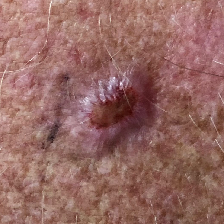

In [12]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img


example_img_id = "PAT_8_15_820.png"  # Cambiar 

# Construir la ruta completa de la imagen
img_path = f"{data_dir}{example_img_id}"


img = load_img(img_path, target_size=(224, 224))  # Redimensionarla a 224x224

# Convertir la imagen a un array y normalizarla
x = img_to_array(img) / 255.0

print(f"Imagen cargada correctamente desde: {img_path}")

array_to_img(x)

In [13]:
x.shape

(224, 224, 3)

### MODELO

In [27]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

data_augmentation = Sequential()

data_augmentation.add(layers.RandomFlip("horizontal"))  # Volteo horizontal
data_augmentation.add(layers.RandomZoom(0.1))           # Zoom aleatorio
data_augmentation.add(layers.RandomTranslation(0.2, 0.2)) # Traslación aleatoria
data_augmentation.add(layers.RandomRotation(0.1))        # Rotación aleatoria
data_augmentation.add(layers.RandomContrast(0.2))        # Contraste aleatorio
data_augmentation.add(layers.RandomHeight(0.1))          # Desplazamiento aleatorio en altura
data_augmentation.add(layers.RandomWidth(0.1))           # Desplazamiento aleatorio en ancho

inputs = layers.Input(shape=(224, 224, 3)) 

x = data_augmentation(inputs)  

x = preprocess_input(x)

# sin la clasificacion
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False


x = base_model(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation="relu")(x)  # Capa densa con más unidades
x = layers.Dropout(0.5)(x)                  # Dropout para prevenir overfitting
x = layers.Dense(128, activation="relu")(x)  # Otra capa densa
x = layers.Dropout(0.5)(x)                  # Más dropout


pred = layers.Dense(1, activation="sigmoid")(x)


model = Model(inputs=inputs, outputs=pred)


model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, None,      │          0 │ input_layer_13[0… │
│ (Sequential)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, None,      │          0 │ sequential_5[0][… │
│ (GetItem)           │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, None,      │          0 │ sequential_5[0][… │
│ (GetItem)           │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, None,      │          0 │ sequential_5[0][… │
│ (GetItem)           │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_4 (Stack)     │ (None, None,      │          0 │ get_item_12[0][0… │
│                     │ None, 3)          │            │ get_item_13[0][0… │
│                     │                   │            │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, None,      │          0 │ stack_4[0][0]     │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, None,      │ 14,714,688 │ add_4[0][0]       │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     32,896 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │        129 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,879,041 (56.76 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [28]:
##compilacion
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Precision, Recall, AUC

adam = optimizers.Adam(learning_rate=0.001)


model.compile(
    loss='binary_crossentropy',  
    optimizer=adam, 
    metrics=['accuracy', Precision(), Recall(), AUC()]  # Añadimos AUC como métrica
)

In [29]:
from tensorflow.keras import callbacks


MODEL = "model.keras"  #aqui tuve que cambiar el nombre

modelCheckpoint = callbacks.ModelCheckpoint(MODEL,
                                            monitor="val_loss",  
                                            verbose=0,  
                                            save_best_only=True)  


LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                        factor=0.1,  
                                        patience=3,  
                                        verbose=1,  
                                        min_lr=0)  

# Detenemos el entrenamiento temprano si la pérdida de validación no mejora
EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', 
                                       patience=10,  
                                       verbose=0,  
                                       restore_best_weights=True)  # Restauramos los mejores pesos después de parar

In [37]:
#cargar los datos


In [32]:

%%time
history = model.fit(
        train_data_dir,
        epochs=30,
        validation_data=test_data_dir,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper])

ValueError: Unrecognized data type: x=/Users/mauricio/code/Kriskitt/melanoma_detector/melanoma_detector/imgs_part_1/training_set/ (of type <class 'str'>)

In [ ]:
#plot_history(history)

In [ ]:
#plot_compare_history(history, "Basic CNN", history_3, "Transfer Learning")

In [ ]:
#plot_compare_history(history_2, "Augmentation", history_3, "Augmentation + Transfer Learning")

## Save and use the model

In [ ]:
model_3.save("model_3")

In [ ]:
from tensorflow.keras.models import load_model

model_3 = load_model("model_3")

In [ ]:
from PIL import Image
import requests
from io import BytesIO

def getImage(url):
    '''Grabs an image based on its URL, and resize it
    '''
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    img = img.resize((150, 150))
    return img

def predictImage(url, model):
    '''Takes an image and a model
    '''
    img = getImage(url)
    img = img_to_array(img)
    img = img.reshape((-1, 150, 150, 3))
    res = model.predict(img)[0][0]
    if(res < 0.5):
        animal = "cat"
        prob = 1-res
    if(res >= 0.5):
        animal = "dog"
        prob = res

    print("Animal : ", animal)
    print("probability = ",prob)

In [ ]:
cat = "https://www.wikichat.fr/wp-content/uploads/sites/2/comment-soigner-une-plaie-dun-chat.jpg"
cat2 = "http://create.votreveterinaire.com/adm/webmaster/_empty/upload/chat_surpris.jpg"


dog = "https://images.sudouest.fr/2018/04/14/5ace461a66a4bd2b1780a0dd/widescreen/1000x500/on-ignore-si-le-chihuahua-a-deserte-ou-non-les-locaux-de-la-clinique.jpg?v1"
dog2 = "https://ds1.static.rtbf.be/article/image/370x208/7/8/f/a20f02dfccd07952da54a7f9a82b3e89-1524657315.jpg"

In [ ]:
predictImage(cat, model_3)

In [ ]:
predictImage(cat2, model_3)

In [ ]:
predictImage(dog, model_3)

In [ ]:
predictImage(dog2, model_3)